
# Recursive Multi-Scale Channel-Spatial Attention for Fine-Grained Image Classification
![title](IEICE2022_.Attention_Module.jpg)



In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torchsummary import summary

### Basic Convolutional Block

In [3]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


### Flatten

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

### Channel Wise Attention

![title](Channel_Wise_Attention.jpg)

##### 
1. Feature dibagi lagi manjadi 2 lalu dilakukan operasi Global Average Pooling (GAP) dan Global Max Pooling (GMP) ukuran feature menjadi 1x1 x 2048.
2. Setiap Feature(GMP,GAP) dibagi lagi menjadi 3 dirumbah kondisi menjadi datar dengan flatten.
3. Lalu melakukan operasi Fully Connected layer dengan setiap feature memiliki output channels 256/128/64.
4. Setiap feature (GMP 256/128/64, GAP 256/128/64) meplalukan operasi Activation Function (Relu)
5. Melakukan Operasi FC lagi dengan semua Feature memiliki output channels sebesar 2048
6. melakukan operasi sum ke semua feature ((GMP 256 + GMP 128 + GMP 64) +( GMP 256+ GMP 128+ GMP 64))
7. Activation Function (Sigmoid) dan melakukan reshape menjadi 7x7 x 2048
8. melakuakan operasi perkalian dengan input feature 

In [5]:
class Channel_Wise_Attention(nn.Module):
    def __init__(self, gate_channels, pool_types=['avg', 'max']):
        super(Channel_Wise_Attention, self).__init__()
        self.gate_channels = gate_channels

        #output channels 8
        self.mlp = nn.Sequential(
                Flatten(),
                nn.Linear(gate_channels, gate_channels // 8),
                nn.ReLU(),
                nn.Linear(gate_channels // 8, gate_channels)
            )
        #output channels 16
        self.mlp2 = nn.Sequential(
                Flatten(),
                nn.Linear(gate_channels, gate_channels // 16),
                nn.ReLU(),
                nn.Linear(gate_channels // 16, gate_channels)
                )
        #output channels 32
        self.mlp3 = nn.Sequential(
                Flatten(),
                nn.Linear(gate_channels, gate_channels // 32),
                nn.ReLU(),
                nn.Linear(gate_channels // 32, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):

        channel_att_sum = None
        for pool_type in self.pool_types:
                # GAP
                if pool_type=='avg':
                    avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                    channel_att_raw = self.mlp( avg_pool ) +self.mlp2( avg_pool ) +self.mlp3( avg_pool )
                # GMP
                elif pool_type=='max':
                    max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                    channel_att_raw = self.mlp( max_pool ) + self.mlp2( max_pool ) + self.mlp3( max_pool )

                # GAP + GMP
                if channel_att_sum is None:
                    channel_att_sum = channel_att_raw
                else:
                    channel_att_sum = channel_att_sum + channel_att_raw

        # sigmoid reshape
        scale = F.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        #input x 
        return x * scale
 


### Spatial Wise Attention

![title](Spatial_Wise_Attention.jpg)

##### 
1. input Feature dibagi menjadi 2 lalu dilakukan operasi channel wise average(CAP) dan max pooling(CMP) dari ukuran 7x7 x 2048 menjadi 2(7x7 x 1)
2. hasil dari CAP dan CMP di gabungkan secara channel wise menjadi 7x7 x2 
3. dibagi menjadi tiga untuk melakukan operasi basic convolution block terdiri dari conv2d, BatchNorm2d dan Relu dengan kernel size 7x7, 5x5, 3x3 memiliki output 7x7 x 1 sebanyak 7
4. melakukan operasi sum ke setiap feature
5. activation function(sigmoid)
6. operasi perkalian matrix dengan input feature


In [6]:
#Concatenate CAP dan CMP
class ChannelPooling(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
    
class Spatial_Wise_Attention(nn.Module):
    def __init__(self):
        super(Spatial_Wise_Attention, self).__init__()
        #Concatenate CAP dan CMP
        self.compress = ChannelPooling()

        #Convolution block 7x7
        self.spatial = BasicConv(2, 1, 7, stride=1, padding=(7-1) // 2, relu=False)

        #Convolution block 5x5
        self.spatial2 = BasicConv(2, 1, 5, stride=1, padding=(5 - 1) // 2, relu=False)

        #Convolution block 3x3
        self.spatial3 = BasicConv(2, 1, 3, stride=1, padding=(3 - 1) // 2, relu=False)

    def forward(self, x):

        #Concatenate CAP dan CMP
        x_compress = self.compress(x)
        #sum Convolution block
        x_out = self.spatial(x_compress) + self.spatial2(x_compress) + self.spatial3(x_compress)
        
        # sigmoid 
        scale = F.sigmoid(x_out)
        return x * scale

### RMCSAM

1. Tambahkan Hasil dari Channel Wise Attention dan Spatial Wise Attention menjadi output1
2. dari output1 lakukan perulangan operasi sebanyak 3 kali 


In [7]:
class RMCSAM(nn.Module):
    def __init__(self, gate_channels, pool_types=['avg', 'max']):
        super(RMCSAM, self).__init__()
        
        #init CWA dan SWA
        self.Channel_Wise_Attention = Channel_Wise_Attention(gate_channels, pool_types)
        self.Spatial_Wise_Attention = Spatial_Wise_Attention()

    def forward(self, x):
        
        #input -> output1
        res = x
        x_out = self.Channel_Wise_Attention(x)
        x_out_2 = self.Spatial_Wise_Attention(res)

        #output1 -> output2
        xb = x_out + x_out_2
        resb = xb
        x_outb = self.Channel_Wise_Attention(xb)
        x_out_2b = self.Spatial_Wise_Attention(resb)

        #output2 -> output3
        xc = x_outb + x_out_2b
        resc = xc
        x_outc = self.Channel_Wise_Attention(xc)
        x_out_2c = self.Spatial_Wise_Attention(resc)

        #output3
        return x_outc + x_out_2c


### Network Warper
menggabungkan Resnet50 dengan RMCSAM 

In [8]:

def gem(x, p=3, eps=1e-6):
    return nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)


class Network_Warper(nn.Module):

    def __init__(self, layers_1, feature_dim=2048, num_class=200, net_case="RMCSAM"):
        super().__init__()
        self.layers_1 = layers_1
        self.net_case = net_case
        self.layers_2 = nn.Linear(feature_dim, num_class)
        # use FC ResNet40
        if net_case == "baseline":
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # use RMCSAM
        elif net_case == "RMCSAM":
            self.RMCSAM = RMCSAM(feature_dim)
        else:
            print("unknown net_case")


    def forward(self, x):
        #ResNet50
        x = self.layers_1(x)
        if self.net_case == "baseline":
            x = self.pool(x).view(x.shape[0], -1)
        #RMCSAM
        elif self.net_case == "RMCSAM":
            x = self.RMCSAM(x)
            # Average Pool and Flatten
            x = gem(x).view(x.shape[0], -1)
        else:
            print("unknown net_case")

        x = self.layers_2(x)

        return x

### ResNet50
import pretrained ResNet50

In [28]:
import timm
#import resnet
model = timm.create_model('resnet50', pretrained=True)

#import hidden layer resnet
model_layers = list(model.children())
m = model_layers[:-2]
m = nn.Sequential(*m)

#inisialisasi model dan penggabungan resnet dengan RMCSAM
model = Network_Warper(m, feature_dim=2048, num_class=7, net_case="RMCSAM")

train =False

### Summary

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
         Identity-10           [32, 64, 56, 56]               0
             ReLU-11           [32, 64, 56, 56]               0
         Identity-12           [32, 64, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

### Dataset

In [11]:
class CustomDataset(Dataset):
    
    def __init__(self, dataset, transform=None):
        self.data, self.targets = self.split_data_with_targets(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # grab the data
        image = self.data[index]
        label = self.targets[index]

        # check for transform
        if self.transform is not None:
            image = self.transform(image)

        return image, torch.FloatTensor([label])

    def split_data_with_targets(self, dataset):
        images = []
        labels = []
        for image, label in dataset:
            images.append(image)
            labels.append(label)
        return images, labels
    
# resize the image and transform to tensor
transformations = transforms.Compose([transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root="dataset")
custom_dataset = CustomDataset(dataset=dataset, transform=transformations)

# Stratified Sampling for train and val
train_idx, validation_idx = train_test_split(np.arange(len(custom_dataset)),
                                             test_size=0.1,
                                             random_state=1,
                                             shuffle=True,
                                             stratify=custom_dataset.targets)

# Subset dataset for train and val
training_dataset = Subset(custom_dataset, train_idx)
validation_dataset = Subset(custom_dataset, validation_idx)

train_labels = []
for image, label in training_dataset:
    train_labels.append(label)

val_labels = []
for image, label in validation_dataset:
    val_labels.append(label)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

### Trainer

In [30]:
from torch import optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

train =True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Function to compute accuracy

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)


# Initialize the scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping parameters
best_val_loss = float('inf')
early_stop_count = 0
patience = 15  # You can adjust this based on your preference

plot_Train_acc = []
plot_loss = []
plot_val_loss = []
plot_val_acc=[]


# Training Loop
num_epochs = 50
for epoch in range(num_epochs):  # num_epochs is the number of epochs

    if device == torch.device('cpu'):
        train= False
        break

    model.train()
    running_loss = 0.0
    total_correct = 0.0
    total_samples = 0.0
    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        labels = labels.view(-1) if len(labels.shape) > 1 else labels

        # Ensure labels has data type torch.long
        labels = labels.type(torch.long)

        # Forward + backward + optimize
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_correct += torch.sum(torch.argmax(outputs, 1) == labels.data)
#         total_correct += 1
        total_samples += inputs.size(0)
        running_loss += loss.item()
    plot_Train_acc.append(total_correct/total_samples)
    plot_loss.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_acc = 0.0
        for inputs, labels in val_loader:

            labels = labels.view(-1) if len(labels.shape) > 1 else labels

            # Ensure labels has data type torch.long
            labels = labels.type(torch.long)

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            val_loss += loss.item()
            val_acc += acc

        plot_val_loss.append(val_loss/len(val_loader))
        plot_val_acc.append(val_acc)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)},Acc: {total_correct/total_samples}, Val Loss: {val_loss}, Val Acc: {val_acc}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
        # Save the model checkpoint if needed
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping! Validation loss has not improved.")
        break

    # Step the learning rate scheduler
    scheduler.step()
print("Training complete")


Epoch [1/50], Loss: 0.8663326686467318,Acc: 0.7159926295280457, Val Loss: 0.46074424032121897, Val Acc: 0.8984375
Epoch [2/50], Loss: 0.301526906530318,Acc: 0.90625, Val Loss: 0.38451152679044753, Val Acc: 0.8984375
Epoch [3/50], Loss: 0.17648982894838006,Acc: 0.9411764740943909, Val Loss: 0.3645010844338685, Val Acc: 0.8984375
Epoch [4/50], Loss: 0.10336999710146783,Acc: 0.9733455777168274, Val Loss: 0.32800934079568833, Val Acc: 0.90625
Epoch [5/50], Loss: 0.09759483672207674,Acc: 0.9641544222831726, Val Loss: 0.3340381271846127, Val Acc: 0.890625
Epoch [6/50], Loss: 0.07121364109972252,Acc: 0.9751838445663452, Val Loss: 0.38552820633049123, Val Acc: 0.890625
Epoch [7/50], Loss: 0.0360384576873484,Acc: 0.9917279481887817, Val Loss: 0.4155865468492266, Val Acc: 0.8984375
Epoch [8/50], Loss: 0.03201007097651895,Acc: 0.9880514740943909, Val Loss: 0.3712982343568001, Val Acc: 0.8984375
Epoch [9/50], Loss: 0.02858441046686601,Acc: 0.9908088445663452, Val Loss: 0.36494129613856785, Val Acc

### Loss and Accuracy

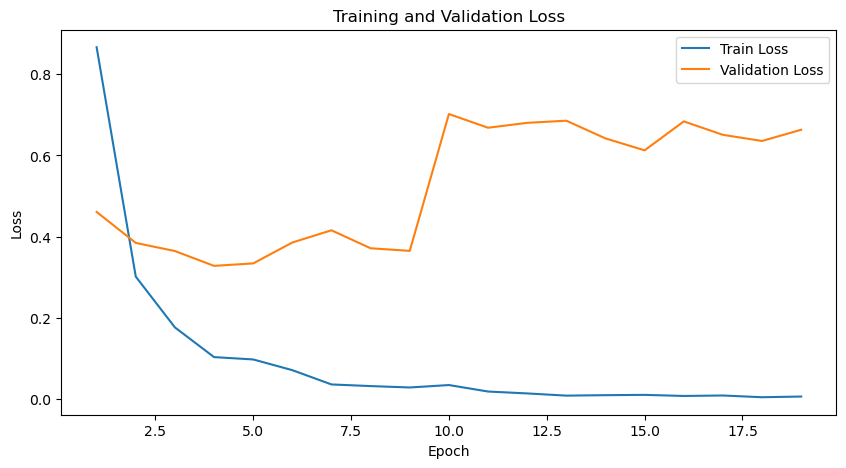

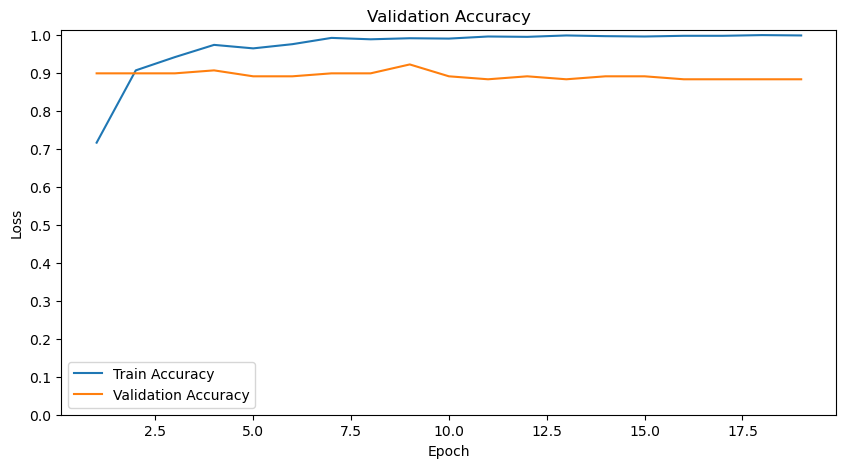

train loss   : 0.006
val loss   : 0.663
train acc  : 99
val acc   : 88
Total epoch   : 19


In [31]:
if train is False:
    import pickle
    file_path = 'eval_ResNet50_RMCSAM_E38_19 Des.pkl'

    with open(file_path, 'rb') as file:
        loaded_eval_dict = pickle.load(file)


    plot_loss = loaded_eval_dict['train_loss']
    plot_Train_acc = loaded_eval_dict['train_acc']
    plot_val_loss = loaded_eval_dict['val_loss']
    plot_val_acc = loaded_eval_dict['val_acc']
    


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(plot_loss) + 1), plot_loss, label='Train Loss')
plt.plot(range(1, len(plot_val_loss) + 1), plot_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))

# plot_val_acc_clone = plot_val_acc.clone().detach()
plot_val_acc_clone = torch.tensor(plot_val_acc)

# plot_Train_acc_clone = plot_Train_acc.clone().detach()
plot_Train_acc_clone = torch.tensor(plot_Train_acc)

plt.plot(range(1, len(plot_Train_acc_clone) + 1), plot_Train_acc_clone, label='Train Accuracy')
plt.plot(range(1, len(plot_val_acc_clone) + 1), plot_val_acc_clone, label='Validation Accuracy')
plt.yticks(np.arange(0.0,1.1,step=0.1))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

print("train loss   : %.3f"%plot_loss[-1])
print("val loss   : %.3f"%plot_val_loss[-1])
print("train acc  : %d"%(plot_Train_acc[-1]*100))
print("val acc   : %d"%(plot_val_acc[-1]*100))

print("Total epoch   : %d"%len(plot_loss))


### Save Model

In [32]:
if train is True:
    import pickle

    strName = "ResNet50_RMCSAM"
    strEpoch = "E19"
    strTgl = "20 Des"

    # Example dictionary with lists
    eval_dict = {
        'train_loss': plot_loss,
        'train_acc': plot_Train_acc_clone,
        'val_loss': plot_val_loss,
        'val_acc': plot_val_acc_clone,
    }

    # Specify the file path where you want to save the dictionary
    file_path = 'eval_'+strName+'_'+strEpoch+'_'+strTgl+'.pkl'

    # Save the dictionary to the file using pickle
    with open(file_path, 'wb') as file:
        pickle.dump(eval_dict, file)

    print(f"Save {file_path}")

    save_path = 'model_'+strName+'_'+strEpoch+'_'+strTgl+'.pth'
    checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
    torch.save(checkpoint, save_path)
    print(f"Save {save_path}")


Save eval_ResNet50_RMCSAM_E19_20 Des.pkl
Save model_ResNet50_RMCSAM_E19_20 Des.pth


### Evaluation

In [33]:
if train is False:
    load_path = 'model_ResNet50_RMCSAM_E38_19 Des.pth'
    checkpoint = torch.load(load_path,map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['state_dict'])
    
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.to('cpu').numpy())
        all_labels.extend(labels.to('cpu').numpy())




### Confusion Matrix

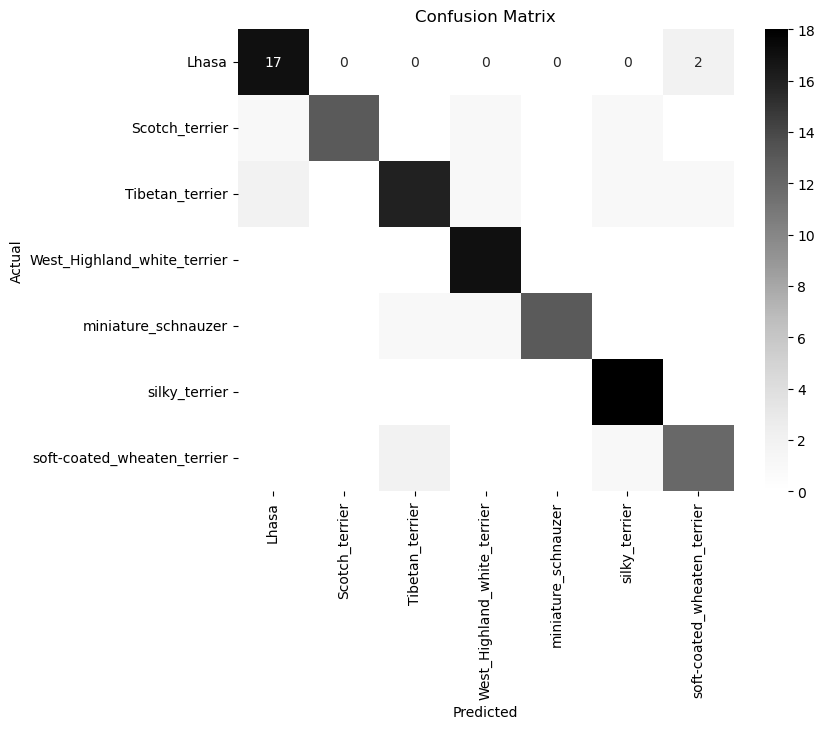


Classification Report:
                             precision    recall  f1-score   support

                      Lhasa       0.85      0.89      0.87        19
             Scotch_terrier       1.00      0.81      0.90        16
            Tibetan_terrier       0.84      0.76      0.80        21
West_Highland_white_terrier       0.85      1.00      0.92        17
        miniature_schnauzer       1.00      0.87      0.93        15
              silky_terrier       0.86      1.00      0.92        18
soft-coated_wheaten_terrier       0.80      0.80      0.80        15

                   accuracy                           0.88       121
                  macro avg       0.89      0.88      0.88       121
               weighted avg       0.88      0.88      0.87       121



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_names = dataset.classes

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Melihat hasil classification report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:")
print(class_report)

### ROC AUC

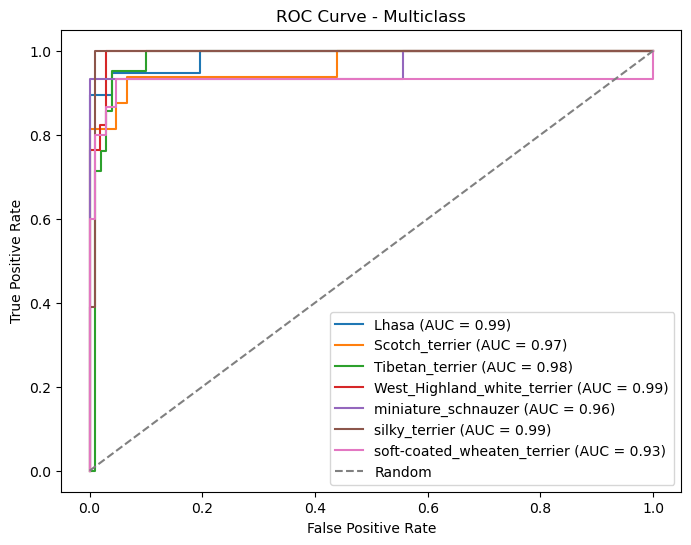

In [35]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_multiclass(fpr_dict, tpr_dict, roc_auc_dict, class_names):
    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(class_names):
        plt.plot(fpr_dict[i], tpr_dict[i], label=f'{class_name} (AUC = {roc_auc_dict[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend()
    plt.show()

def calculate_roc_auc_multiclass(model, data_loader, device, num_classes):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            labels = labels.view(-1) if len(labels.shape) > 1 else labels
            labels = labels.type(torch.long)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    all_labels_onehot = np.eye(num_classes)[all_labels]


    all_labels_onehot = np.array(all_labels_onehot)
    all_probs = np.array(all_probs)


    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)

        fpr_dict[i] = fpr
        tpr_dict[i] = tpr
        roc_auc_dict[i] = roc_auc

    return fpr_dict, tpr_dict, roc_auc_dict

num_classes = len(class_names)  
fpr_dict, tpr_dict, roc_auc_dict = calculate_roc_auc_multiclass(model, val_loader, device, num_classes)
plot_roc_curve_multiclass(fpr_dict, tpr_dict, roc_auc_dict, class_names)




### Test Model

Predicted Label: Lhasa


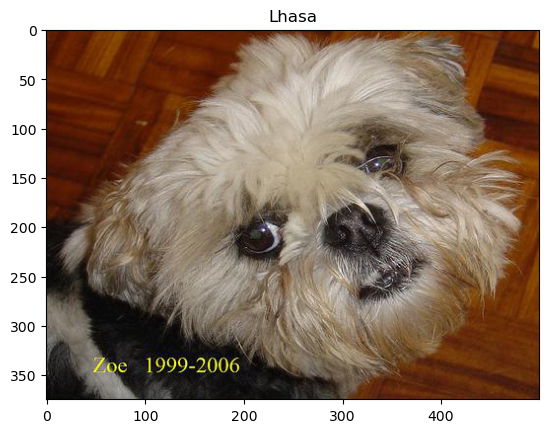

In [41]:
def load_and_process_image(image_path):
   
    image = Image.open(image_path)
    

    transformations = transforms.Compose([transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    
    input_tensor = transformations(image)
    input_batch = input_tensor.unsqueeze(0)  
    
    return input_batch,image

def predict_image(model, image_path):
    
    input_batch,image = load_and_process_image(image_path)

   
    model.eval().to('cpu')

   
    with torch.no_grad():
        output = model(input_batch)

    
    _, predicted_idx = torch.max(output, 1)
    
   
    labels = class_names
    predicted_label = labels[predicted_idx.item()]

    return predicted_label,image

lstest = ['test/n02097474_120.jpg','test/n02098105_3374.jpg','test/n02098413_387.jpg','test/n02098413_49.jpg']

model.eval()

image_path = lstest[2]
  
predicted_label,image = predict_image(model, image_path)

plt.imshow(image)
plt.title(predicted_label)
print(f'Predicted Label: {predicted_label}')

